Zbiór danych: https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland?resource=download

Dataset zawiera informacje o nieruchomościach na sprzedaż w polsce z 2024.06  

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = 'apartments_pl_2024_06.csv'

apartments_data = pd.read_csv(data_path)

num_rows, num_columns = apartments_data.shape

print(f"Liczba rekordów (wierszy): {num_rows}")
print(f"Liczba cech (kolumn): {num_columns}")

pd.set_option('display.max_columns', None)
print(apartments_data.head())

Liczba rekordów (wierszy): 21501
Liczba cech (kolumn): 28
                                 id      city               type  \
0  811891f98a870dfd6e414374a0a85560  szczecin       blockOfFlats   
1  adaf636d0c44d8d9325bce42403eefee  szczecin  apartmentBuilding   
2  9b957bd60885a469c96f17b58a914f4b  szczecin  apartmentBuilding   
3  74fef2ff7135bc70797a3fbfd7d44ed6  szczecin       blockOfFlats   
4  77cc78c75b0d09bf84d6d3124a28803c  szczecin       blockOfFlats   

   squareMeters  rooms  floor  floorCount  buildYear   latitude  longitude  \
0         47.00    2.0    6.0        12.0     1981.0  53.428544  14.552812   
1         88.22    3.0    1.0         2.0     2000.0  53.449093  14.516844   
2        117.00    5.0    4.0         4.0        NaN  53.443096  14.561348   
3         33.31    1.0    1.0         4.0     1963.0  53.436100  14.541200   
4         56.00    3.0    7.0         7.0     2018.0  53.447465  14.557811   

   centreDistance  poiCount  schoolDistance  clinicDistance  \
0

Zbiór zawiera 21501 rekordów, liczba cech w całym zbiorze wynosi 28. Do przeprowadzenia regresji zostaną wykorzystane następujące cechy:

1. squareMeters (metry kwadratowe)  
2. city (miasto)
3. rooms (ilość pokoi)  
4. floor (piętro)  
5. floorCount (ilość pięter w budynku)  
6. buildYear (rok budowy)  
7. latitude i longitude - współrzędne geograficzne lokalizacji mieszkania.  
8. centreDistance (odległość od centrum w km)  
9. schoolDistance (odległość od szkoły) 
10. clinicDistance (odległość od )  
11. pharmacyDistance (odległość od aptek)  
12. collegeDistance (odległość od uczelni)  
13. hasElevator (winda)  - nie posiada / posiada
14. hasParkingSpace (miejsce parkingowe) - nie posiada / posiada  
15. price (cena) - cena mieszkania (zł)  

Zbiór posłuży do przeprowadzenia regresji cen mieszkań, z wykorzystaniem powyższych cech.

In [108]:
selected_columns = [
    "squareMeters", "rooms", "floor", "floorCount", "buildYear",
    "centreDistance", "schoolDistance", "clinicDistance",
    "pharmacyDistance", "hasElevator", "hasParkingSpace", "price"
]

missing_values = apartments_data[selected_columns].isnull().sum()

missing_percentage = (missing_values / len(apartments_data) * 100).round(2).astype(str) + "%"

print("Brakujące wartości dla cech używanych w regresji:")
print(missing_percentage)

Brakujące wartości dla cech używanych w regresji:
squareMeters          0.0%
rooms                 0.0%
floor               16.62%
floorCount           0.97%
buildYear           15.72%
centreDistance        0.0%
schoolDistance       0.05%
clinicDistance       0.29%
pharmacyDistance     0.14%
hasElevator          4.46%
hasParkingSpace       0.0%
price                 0.0%
dtype: object


In [109]:
error_counts = {}

valid_values = {
    "hasElevator": ["tak", "nie"],
    "hasParkingSpace": ["tak", "nie"]
}

for col, valid in valid_values.items():
    invalid_values = apartments_data[apartments_data[col].isin(valid)][col].dropna()
    error_counts[col] = len(invalid_values)

valid_ranges = {
    "squareMeters": (10, 500),
    "rooms": (1, 10),
    "floor": (0, 50),
    "floorCount": (1, 50),
    "buildYear": (1800, 2025),
    "centreDistance": (0, 100),
    "schoolDistance": (0, 100),
    "clinicDistance": (0, 100),
    "pharmacyDistance": (0, 100),
    "price": (50000, 5000000)
}

for col, (min_val, max_val) in valid_ranges.items():
    invalid_values = apartments_data[(apartments_data[col] < min_val) | (apartments_data[col] > max_val)][col]
    error_counts[col] = len(invalid_values)

total_rows = len(apartments_data)
for col, count in error_counts.items():
    percent = round((count / total_rows) * 100, 2)
    print(f"{col.ljust(20)} {str(count).ljust(5)} ({percent}%)")

hasElevator          0     (0.0%)
hasParkingSpace      0     (0.0%)
squareMeters         0     (0.0%)
rooms                0     (0.0%)
floor                0     (0.0%)
floorCount           0     (0.0%)
buildYear            0     (0.0%)
centreDistance       0     (0.0%)
schoolDistance       0     (0.0%)
clinicDistance       0     (0.0%)
pharmacyDistance     0     (0.0%)
price                0     (0.0%)


Zbiór nie zawiera niepoprawnych wartości.  
Występują wartości brakujące dla takich cech jak: 
- piętro, 
- ilość pięter w budynku, 
- rok budowy, 
- odległości od poszczególnych miejsc
- obecność windy



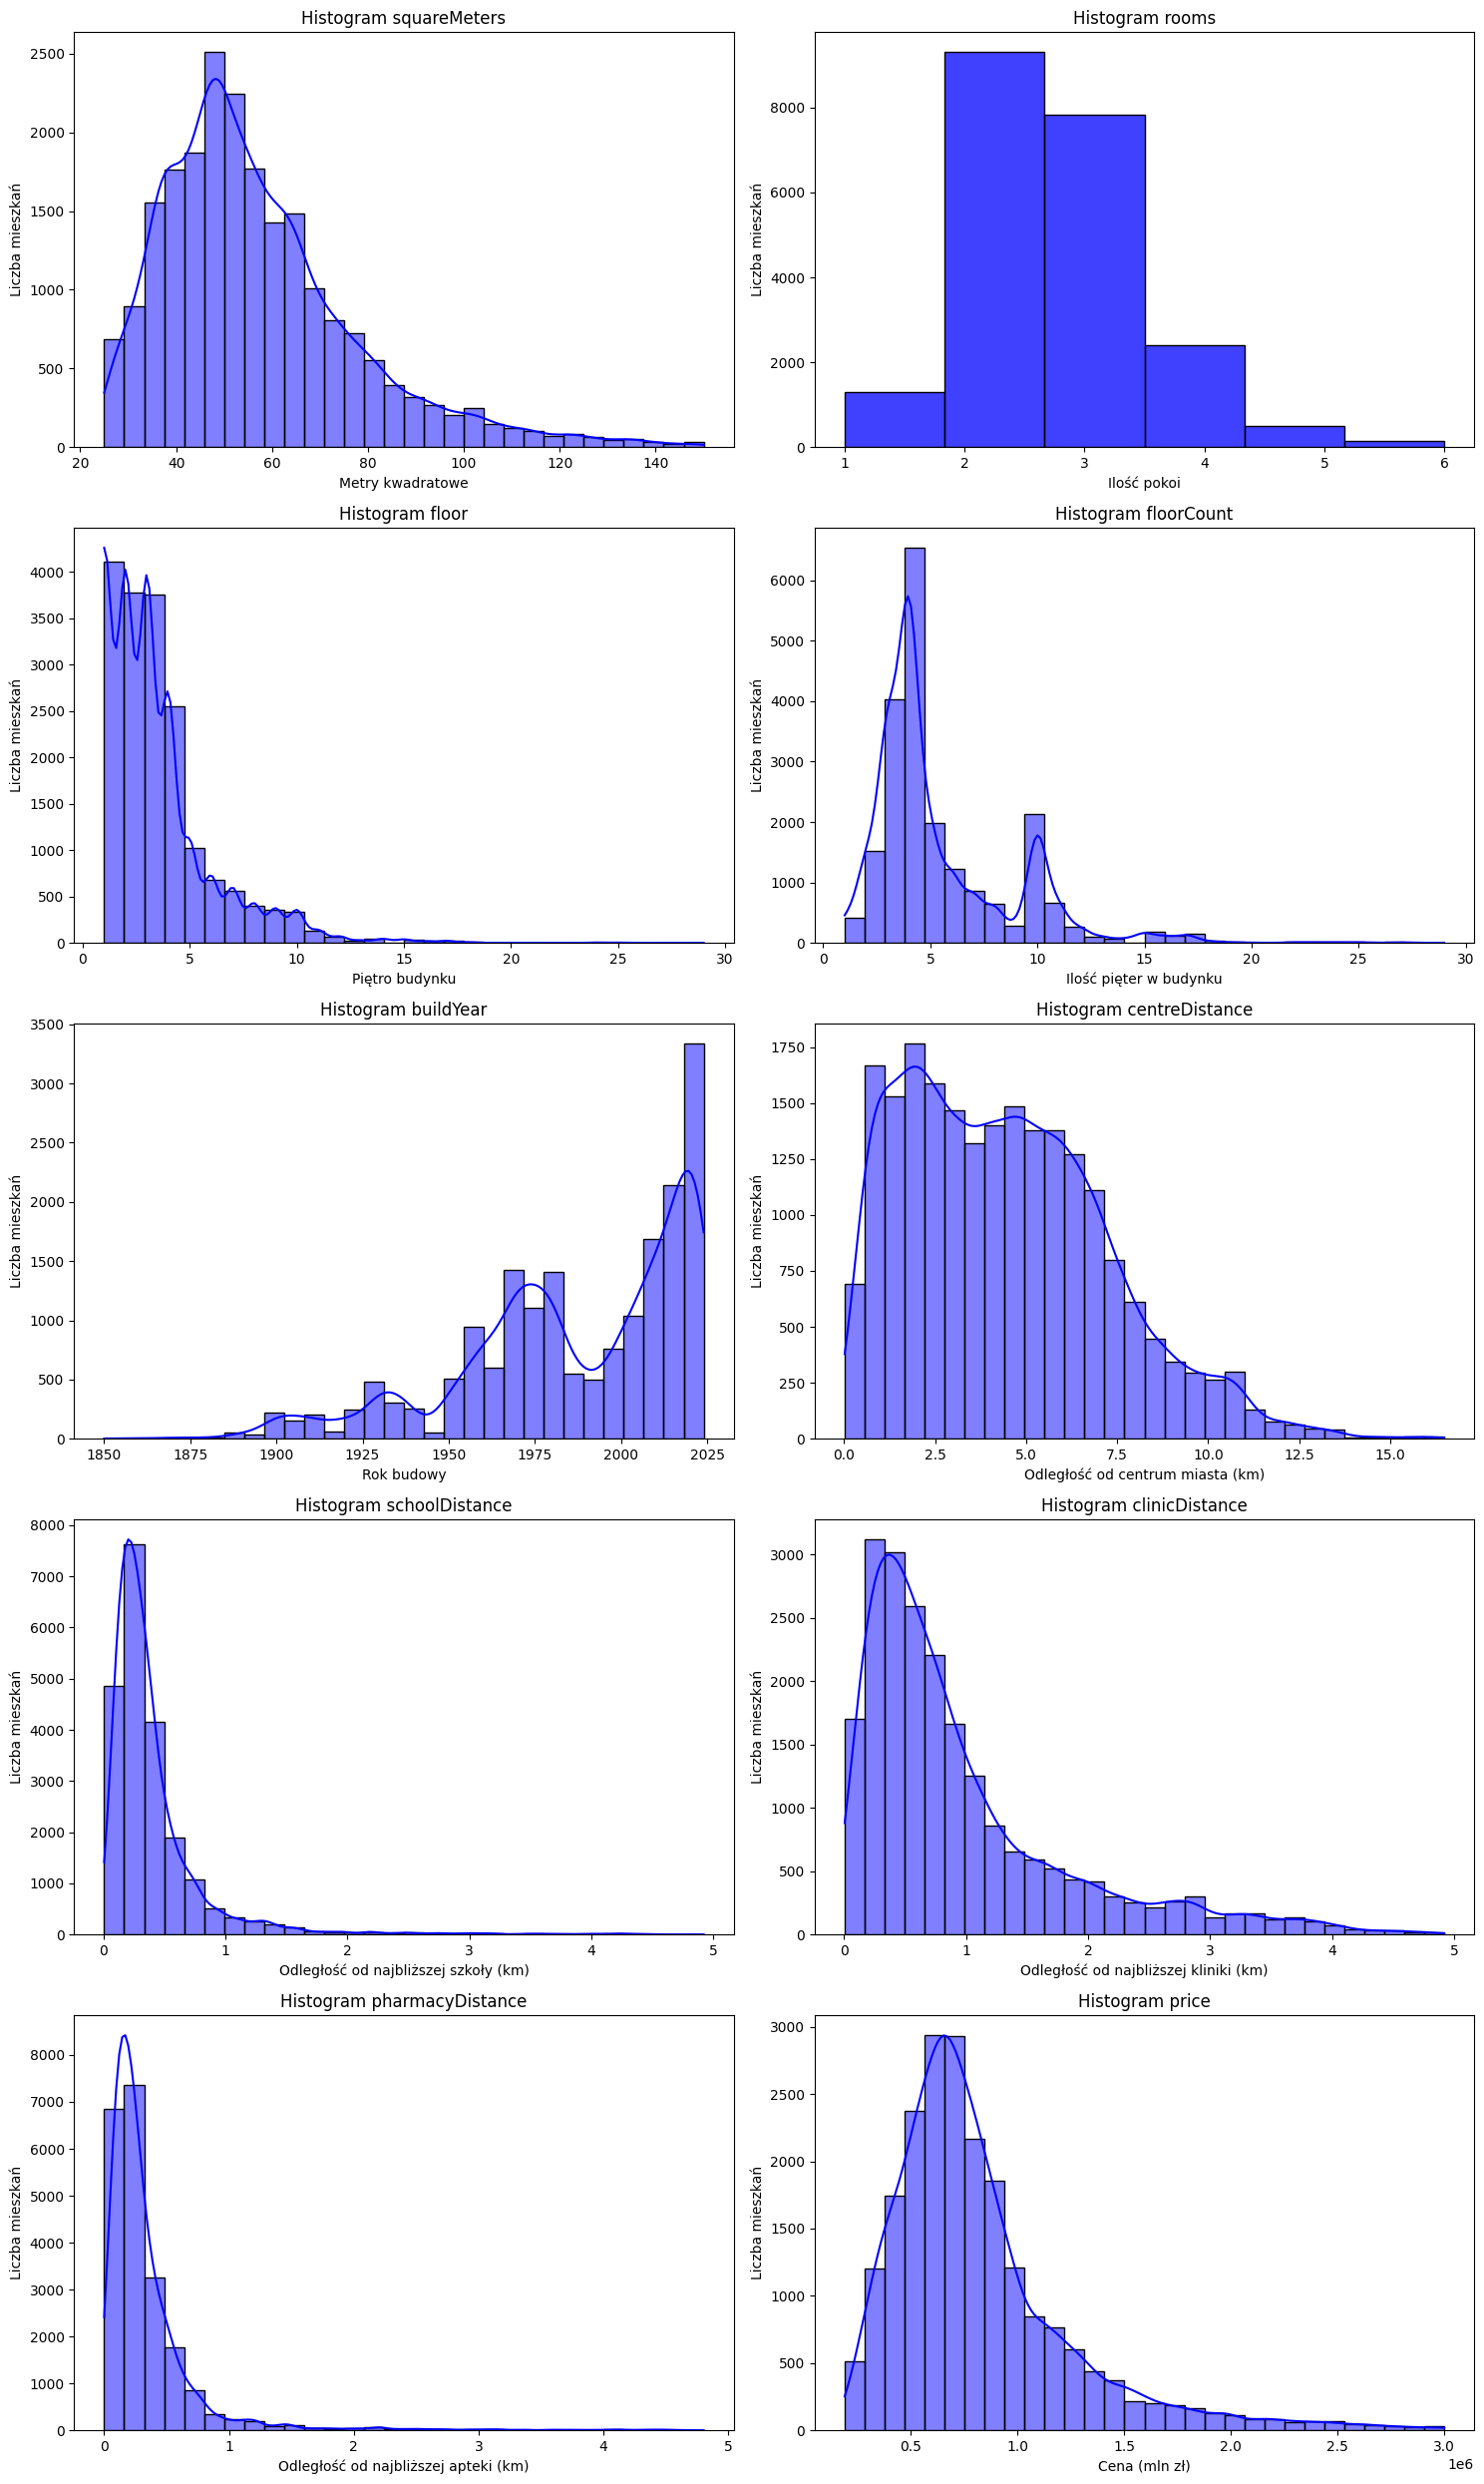

In [110]:
def create_hist_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="blue", bins=30, kde=True):
    sns.histplot(data[column], bins=bins, kde=kde, color=color, ax=axes[index])
    axes[index].set_title(f"Histogram {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)

fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.flatten()

create_hist_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_hist_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi", bins=6, kde=False)
create_hist_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_hist_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_hist_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_hist_plot(5, apartments_data, "centreDistance", axes, xlabel="Odległość od centrum miasta (km)")
create_hist_plot(6, apartments_data, "schoolDistance", axes, xlabel="Odległość od najbliższej szkoły (km)")
create_hist_plot(7, apartments_data, "clinicDistance", axes, xlabel="Odległość od najbliższej kliniki (km)")
create_hist_plot(8, apartments_data, "pharmacyDistance", axes, xlabel="Odległość od najbliższej apteki (km)")
create_hist_plot(9, apartments_data, "price", axes, xlabel="Cena (mln zł)")

plt.tight_layout()
plt.show()

#Dodac opisy

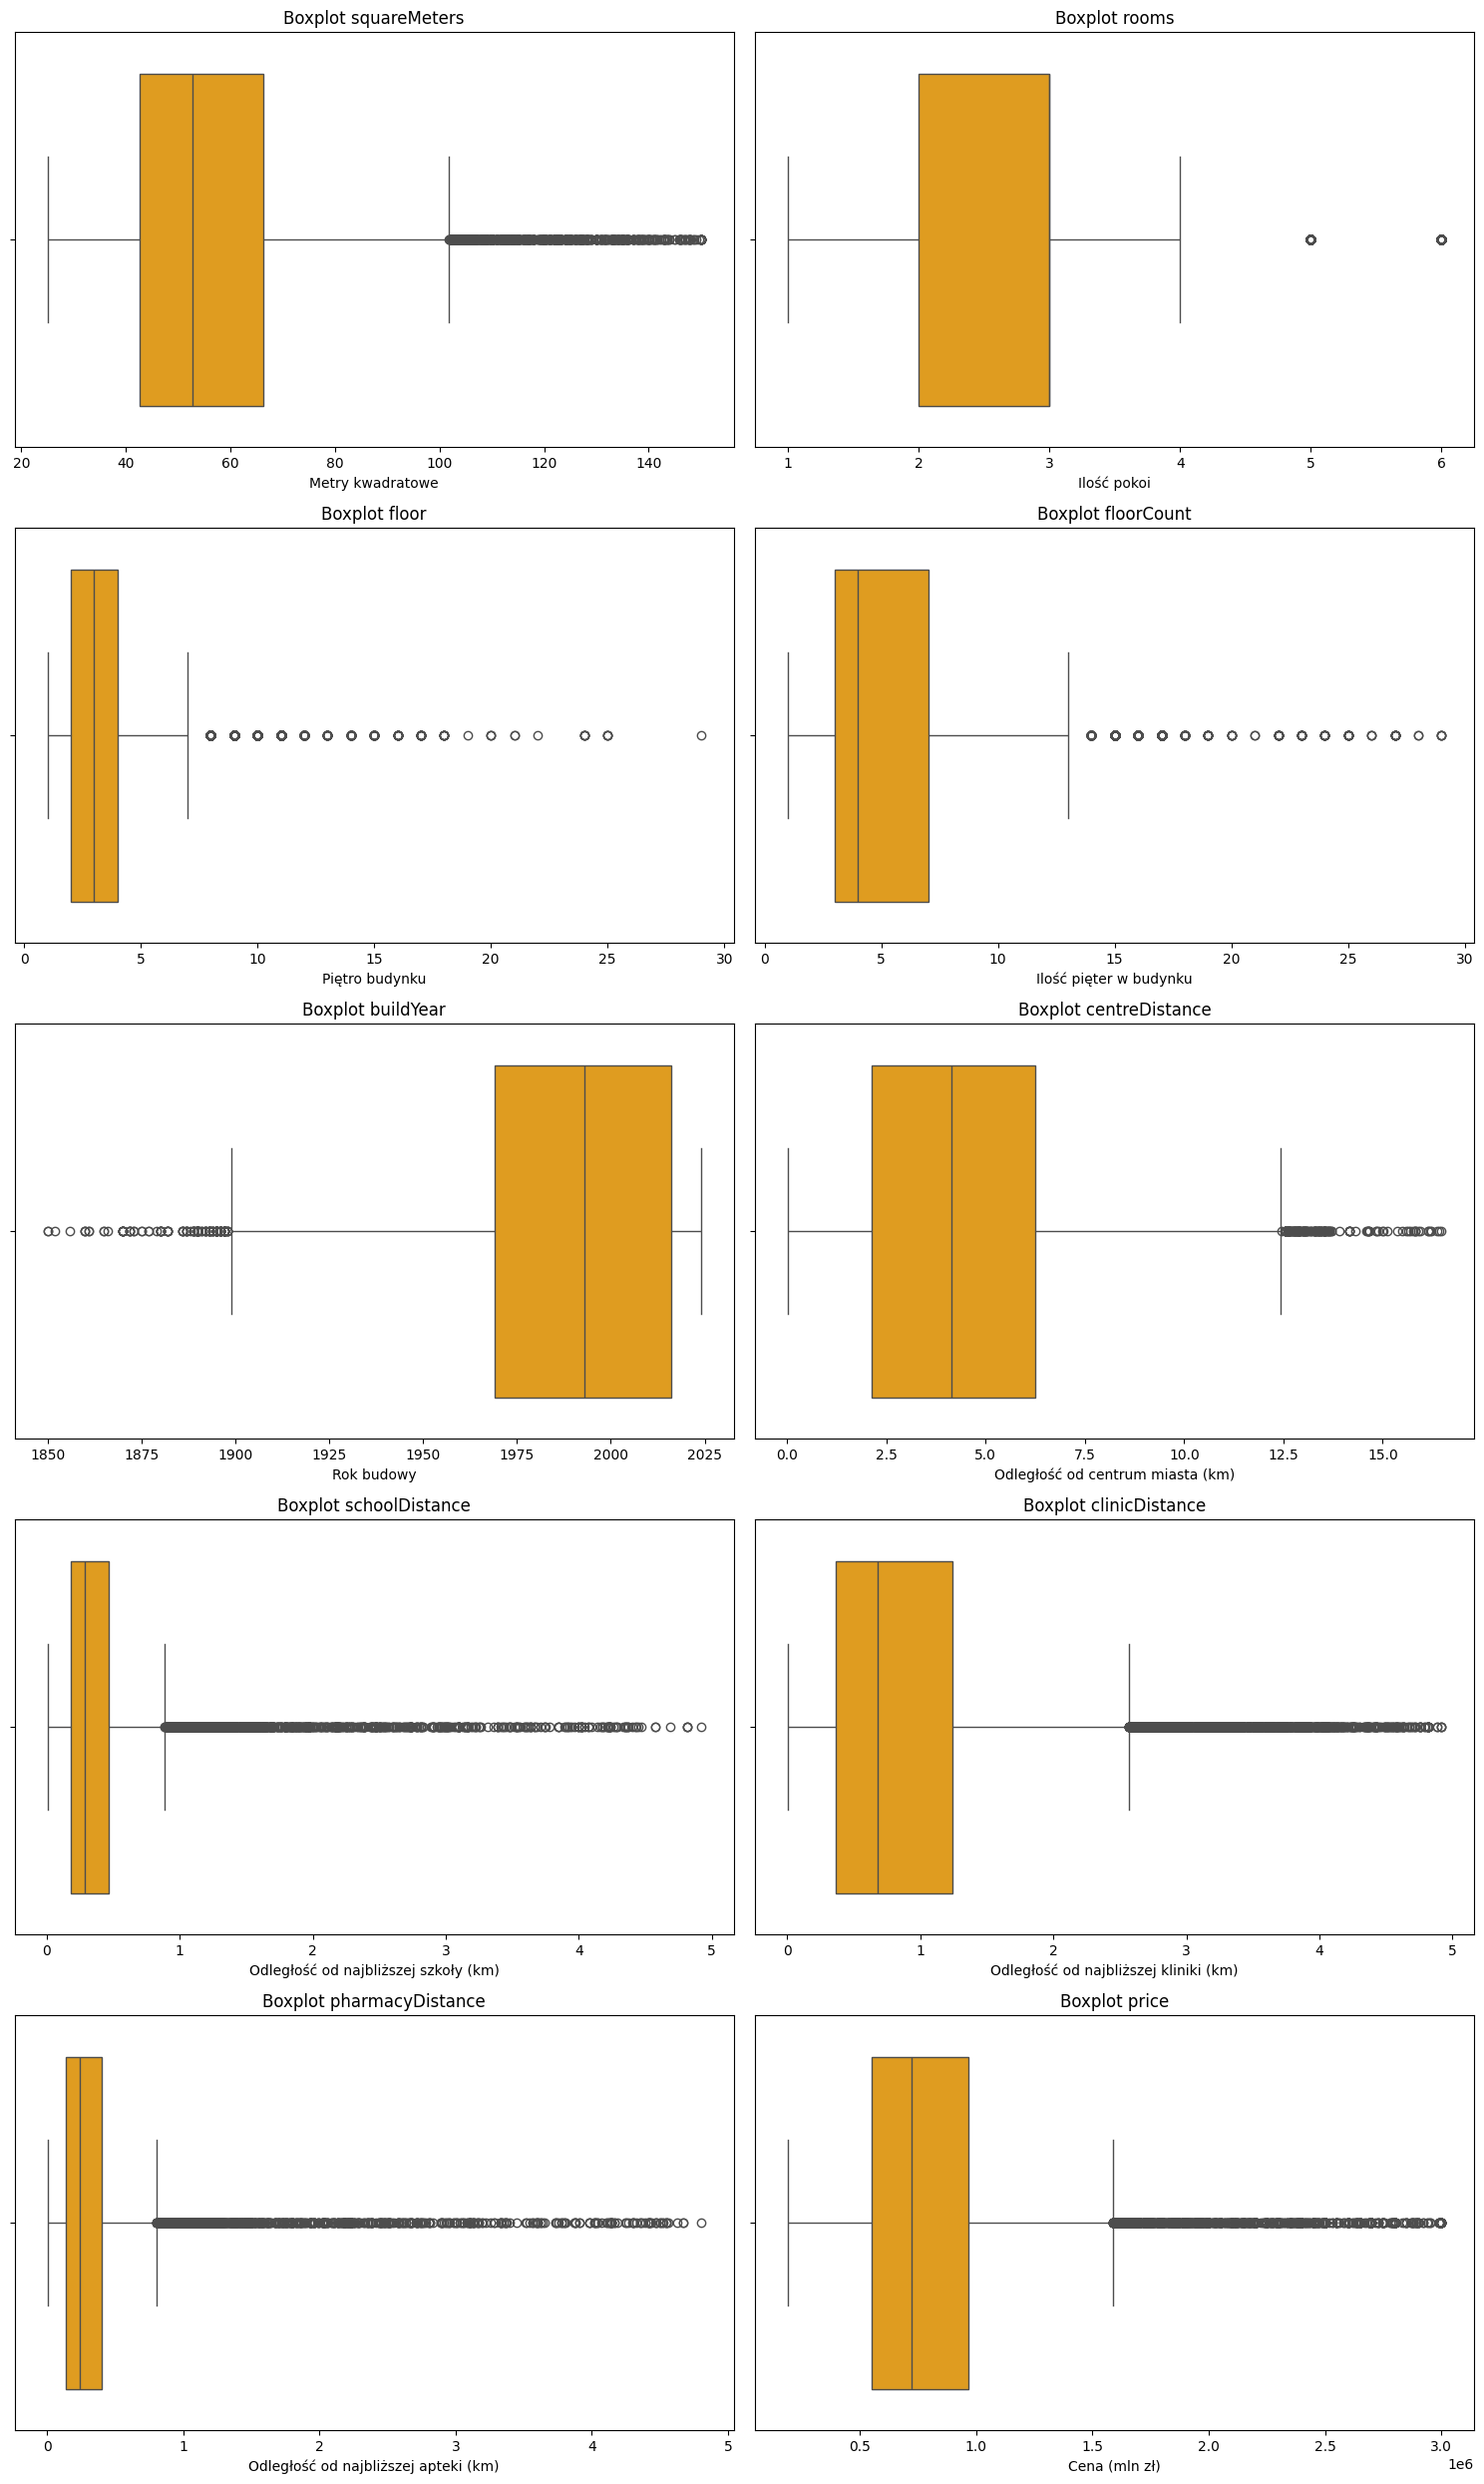

In [111]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.flatten()

create_box_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_box_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi")
create_box_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_box_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_box_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_box_plot(5, apartments_data, "centreDistance", axes, xlabel="Odległość od centrum miasta (km)")
create_box_plot(6, apartments_data, "schoolDistance", axes, xlabel="Odległość od najbliższej szkoły (km)")
create_box_plot(7, apartments_data, "clinicDistance", axes, xlabel="Odległość od najbliższej kliniki (km)")
create_box_plot(8, apartments_data, "pharmacyDistance", axes, xlabel="Odległość od najbliższej apteki (km)")
create_box_plot(9, apartments_data, "price", axes, xlabel="Cena (mln zł)")

plt.tight_layout()
plt.show()

#Dodac opisy

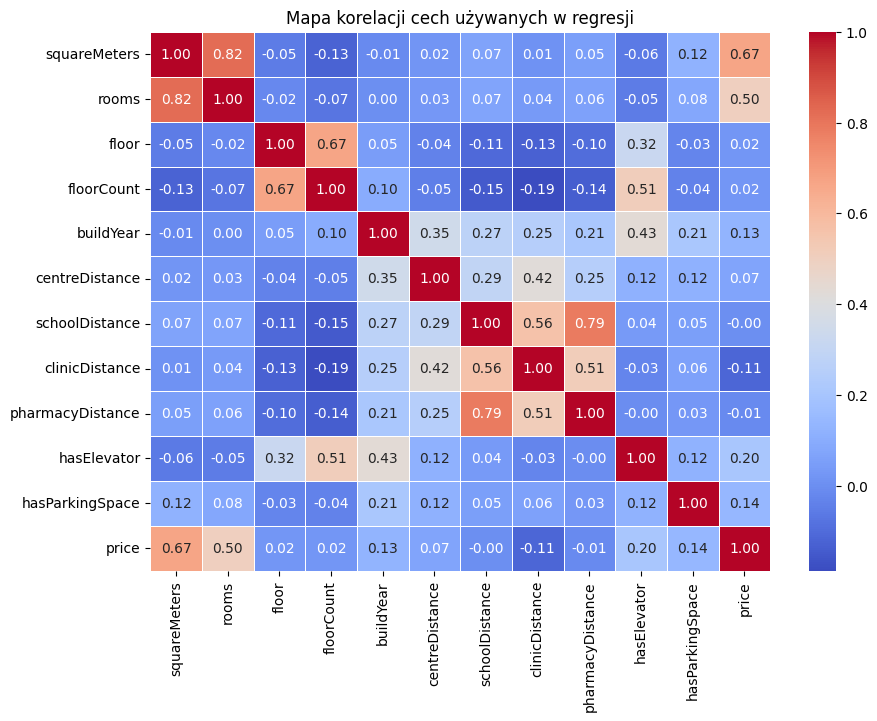

In [112]:
filtered_data = apartments_data[selected_columns].copy()

filtered_data["hasElevator"] = filtered_data["hasElevator"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasParkingSpace"] = filtered_data["hasParkingSpace"].map({"yes": 1, "no": 0}).astype("Int64")

corr_matrix = filtered_data.corr(method='pearson')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

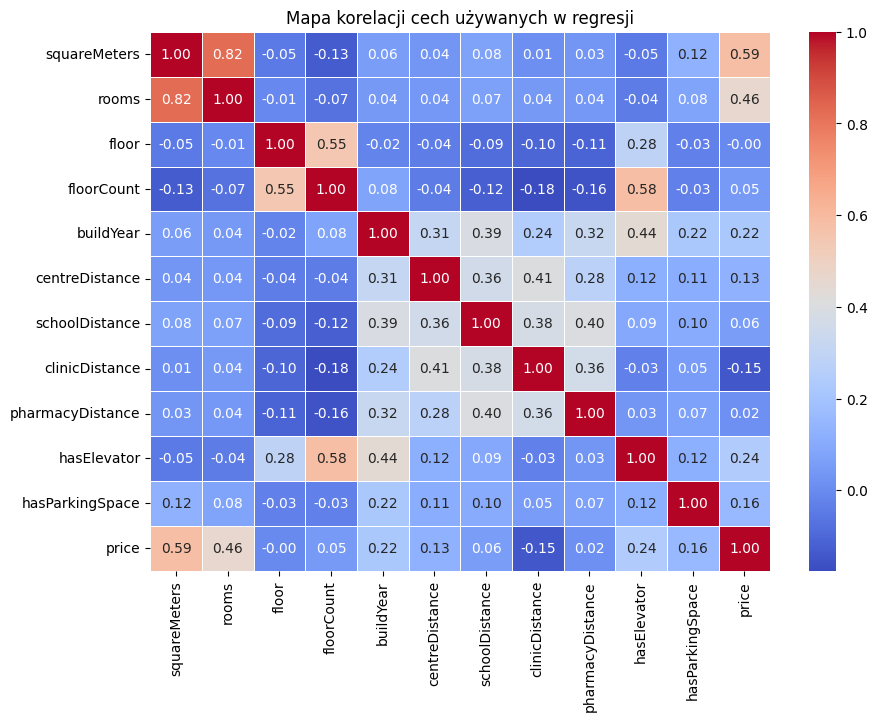

In [113]:
corr_matrix = filtered_data.corr(method='spearman')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()